In [27]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [58]:
n = 15
X, y = make_classification(n_samples=15000, # 1000 observations 
                           n_features=n, # Total features
                           weights=[0.975,0.025],
                           n_informative=2, # 6 informative features
                           n_classes=2, # binary target/label 
                           random_state=0)

In [59]:
col_features = [f'X{i}' for i in range(n)]
col_target = 'y'

df = pd.DataFrame(X)
df.columns = col_features
df[col_target] = y

df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,y
0,-0.002043,-0.330864,-0.857727,0.673381,-1.603143,-0.712370,-0.900495,-1.069549,0.424680,-0.196641,-1.728385,1.024688,-0.367102,0.909199,-1.843846,0
1,-0.826812,-0.934610,-1.634296,-0.982304,-0.038773,0.894099,-0.947106,-0.603800,0.718158,0.445357,1.768142,0.886034,0.377765,-0.690124,-0.087384,0
2,-0.317685,-2.413645,0.217084,0.262636,-0.773253,0.812175,-0.438205,-0.260322,-0.725487,-0.476141,0.986845,1.947322,-0.348038,0.753433,-0.409375,0
3,-0.030487,0.747054,1.049941,0.466796,-2.897540,-0.547849,0.276992,-2.388112,1.273590,0.992151,-1.864002,-0.042830,-0.359107,1.082664,-0.129745,0
4,0.903846,0.642063,0.881494,0.203748,-0.832331,1.110541,2.557068,-0.117557,0.101804,0.980479,1.235215,0.304877,-0.483447,1.011416,-0.311378,0


In [60]:
X_train, X, y_train, y = train_test_split(df[col_features],
                                          df[col_target],
                                          test_size = 0.2,
                                          stratify=df[col_target])
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size = 0.5, stratify = y)

In [61]:
# Hyperparameters of xgb classifier
params_xgb = {'num_class': 2,
              'learning_rate': 0.05,
              'objective': 'multi:softprob',
              'use_label_encoder': False,
              'n_estimators': 1000}

# XGBoost setting and training
cls = xgb.XGBClassifier(**params_xgb).fit(X_train,
                                          y_train,
                                          early_stopping_rounds = 5,
                                          eval_metric = ['merror','mlogloss'],
                                          eval_set = [(X_train, y_train), (X_val, y_val)],
                                          verbose = False)

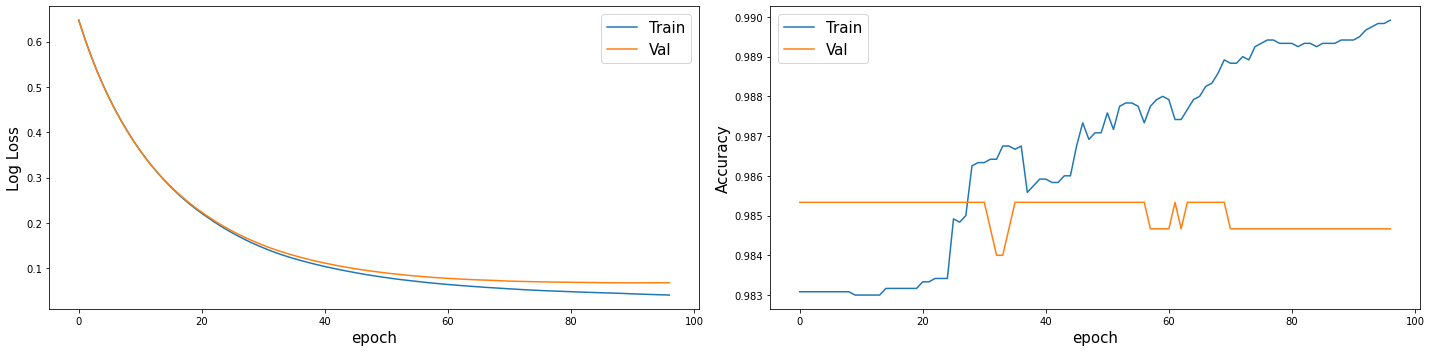

In [62]:
# Training metrics
results = cls.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Plot log loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax1.plot(x_axis, results['validation_1']['mlogloss'], label='Val')
ax1.legend(fontsize=15)
ax1.set_xlabel('epoch', fontsize=15)
ax1.set_ylabel('Log Loss', fontsize=15)

# Plot classification error
ax2.plot(x_axis, [1-x for x in results['validation_0']['merror']], label='Train')
ax2.plot(x_axis, [1-x for x in results['validation_1']['merror']], label='Val')
ax2.legend(fontsize=15)
ax2.set_xlabel('epoch', fontsize=15)
ax2.set_ylabel('Accuracy', fontsize=15)

plt.tight_layout()

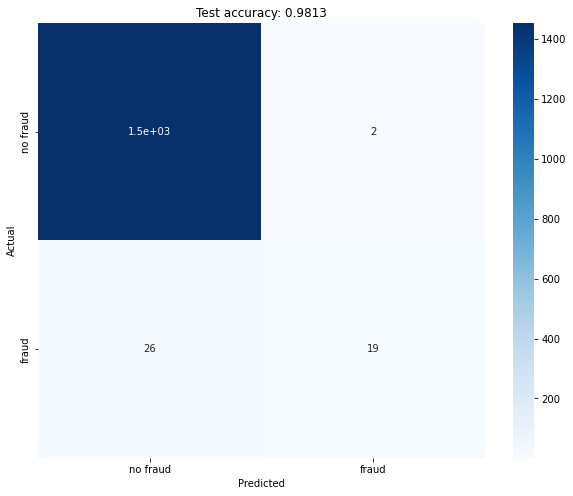

In [65]:
preds = cls.predict(X_test)
res = confusion_matrix(y_test, preds)
labels = ['no fraud', 'fraud']
confusion = pd.DataFrame(res, columns=labels, index = labels)
confusion.index.name, confusion.columns.name = 'Actual', 'Predicted'

plt.figure(figsize = (10,8))
sns.heatmap(confusion, annot=True, cmap='Blues')
plt.title('Test accuracy: %.4f' % (accuracy_score(y_test, preds)))

plt.show()

In [64]:
print(classification_report(preds, y_test, target_names=labels, digits=2))

              precision    recall  f1-score   support

    no fraud       1.00      0.98      0.99      1479
       fraud       0.42      0.90      0.58        21

    accuracy                           0.98      1500
   macro avg       0.71      0.94      0.78      1500
weighted avg       0.99      0.98      0.98      1500

